# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Big Data Real-Time Analytics com Python e Spark</font>

## <font color='blue'>Mini-Projeto 3</font>

### <font color='blue'>Prevendo a Cotação de Criptomoedas em Tempo Real com PySpark e Machine Learning</font>

Leia os manuais em pdf no Capítulo 11 do curso com a definição do problema e a fonte de dados.

![title](imagens/MP3.png)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.7


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
#!pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
# https://pypi.org/project/findspark/
!pip install -q findspark

In [4]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [5]:
# Imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.20.3
pyspark   : 3.3.0
matplotlib: 3.4.3
pandas    : 1.3.4
seaborn   : 0.11.2
findspark : 2.0.1
sys       : 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]



## Preparando o Ambiente Spark

Leia o manual em pdf no Capítulo 11 do curso, com os detalhes sobre como conectamos em um cluster Spark.

In [8]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [9]:
# Criando o Spark Context
sc = SparkContext(appName = "Mini-Projeto3")

22/07/08 14:10:20 WARN Utils: Your hostname, falcon.local resolves to a loopback address: 127.0.0.1; using 10.0.0.84 instead (on interface en0)
22/07/08 14:10:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/08 14:10:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [11]:
# Visualiza o objeto spark_session
spark_session

## Carregando os Dados

In [12]:
# Carrega os dados a partir da sessão Spark
df_spark = spark_session.read.csv('dados/dataset.csv', header = 'true', inferSchema = 'true')

In [13]:
# Tipo do objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [14]:
# Visualiza os dados
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [15]:
# Visualiza os metadados (schema)
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [16]:
# Verifica o número de linhas
df_spark.count()

4856600

## Data Wrangling com SparkSQL

Leia os manuais em pdf no Capítulo 11 do curso com as definições de DataFrames, RDDs, Transformações e Ações.

In [17]:
# Cria uma tabela temporária a partir do dataframe
# As tabelas temporárias são úteis quando você deseja que o conjunto de resultados fique visível 
# para todas as outras sessões Spark
df_spark.createOrReplaceTempView('dados_bitcoin') 

In [18]:
# Executa uma consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from dados_bitcoin")

In [19]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [20]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-30 23:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:20:00|


In [21]:
# Remove valores NA (não faz sentido qualquer tratamento aqui, pois todas as colunas de cotações estão como NA)
df_bitcoin = df_bitcoin.dropna('any')

In [22]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-30 23:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 07:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 08:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 09:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2011-12-31 20:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 07:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 14:45:00|


In [23]:
# Número de registros
df_bitcoin.count()

3613769

In [24]:
# Vamos renomear algumas colunas para facilitar a manipulação dos dados
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [25]:
# Visualiza
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30 23:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 07:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 08:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 09:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31 20:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 07:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 14:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

> A coluna dateTime fornece os detalhes da data da cotação. Vamos separar os elementos da data em diferentes colunas.

In [26]:
# Vamos dividir o dataframe extraindo data
df_data = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [27]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [28]:
# Vamos dividir o dataframe extraindo tempo
df_data = df_data.withColumn("time", split(col("dateTime")," ").getItem(1))

In [29]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [30]:
# Visualiza os dados
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30 23:52:00|2011-12-30|23:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 07:50:00|2011-12-31|07:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 08:59:00|2011-12-31|08:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 09:00:00|2011-12-31|09:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31 20:16:00|2011-12-31|20:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 07:2

In [31]:
# Vamos dividir o dataframe extraindo a hora
df_data_hora = df_data.withColumn("hour", split(col("time"),":").getItem(0))

In [32]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [33]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30 23:52:00|2011-12-30|23:52:00|  23|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 07:50:00|2011-12-31|07:50:00|  07|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 08:59:00|2011-12-31|08:59:00|  08|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 09:00:00|2011-12-31|09:00:00|  09|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31 20:16:00|2011-12-31|20:16:00|  20|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [34]:
# Vamos ajustar o formato da data para extrair o dia da semana
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["dateTime"].cast(DateType()))


In [35]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30|2011-12-30|23:52:00|23.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|07:50:00| 7.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|08:59:00| 8.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|09:00:00| 9.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31|2011-12-31|20:16:00|20.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|07:28:00| 7.0|
|132545790

In [36]:
# Vamos extrair o dia da semana
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [37]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [38]:
# Vamos extrair o ano da cotação
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"),"-").getItem(0))

In [39]:
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30|2011-12-30|23:52:00|23.0|          6|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|07:50:00| 7.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|08:59:00| 8.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|09:00:00| 9.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31|2011-12-31|20:16:00|20.0|  

In [40]:
# Converte o dataframe do Spark para o Pandas. 
# Por quê? Porque isso vai facilitar a análise exploratória de dados.
df_pandas = df_data_hora_ano.toPandas()

In [41]:
type(df_pandas)

pandas.core.frame.DataFrame

In [42]:
# Obtendo os valores individuais para usar nos gráficos
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

## Análise Exploratória

Leia os manuais em pdf no Capítulo 11 do curso com detalhes sobre a forma ideal de fazer análise exploratória.

<AxesSubplot:>

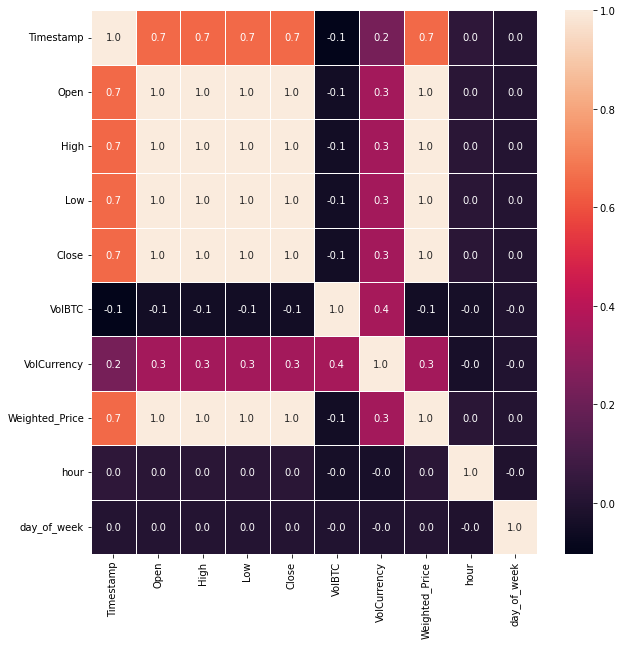

In [43]:
# Heatmap para visualizar a correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

Idealmente queremos alta correlação entre as variáveis de entrada e a variável de saída e baixa correlação entre as variáveis de entrada!

<Figure size 864x360 with 0 Axes>

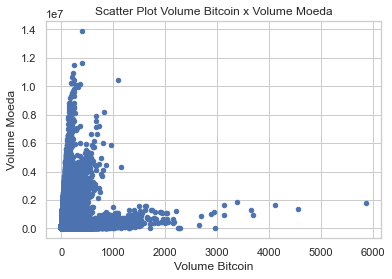

In [44]:
# Scatter Plot Volume Bitcoin x Volume Moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

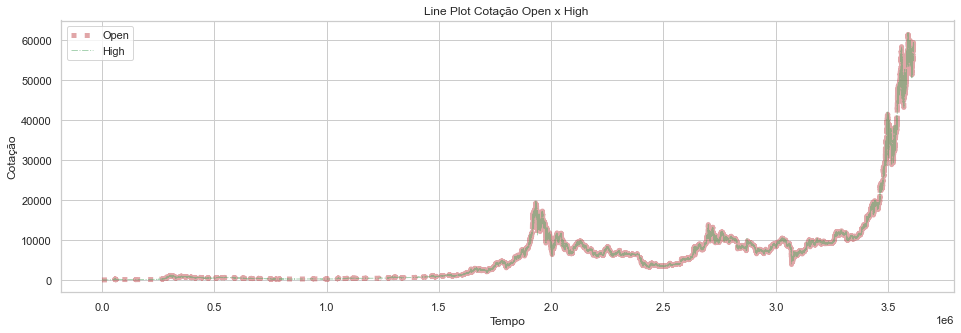

In [45]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

<AxesSubplot:ylabel='Frequency'>

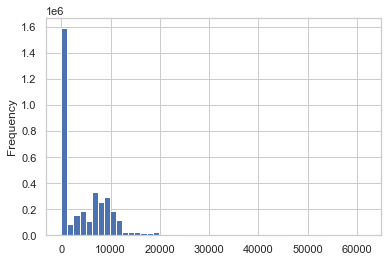

In [46]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

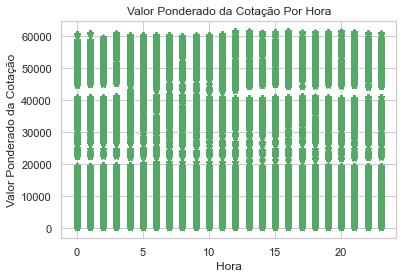

In [47]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

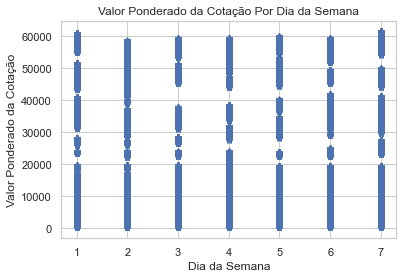

In [48]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

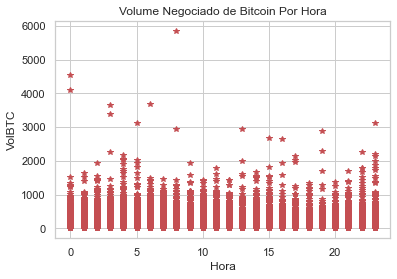

In [49]:
# Plot do VolBTC por hora
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

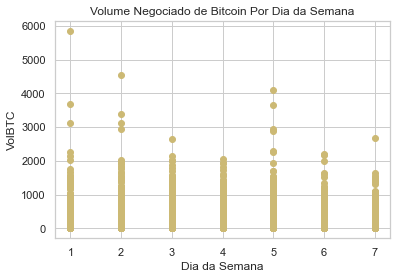

In [50]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

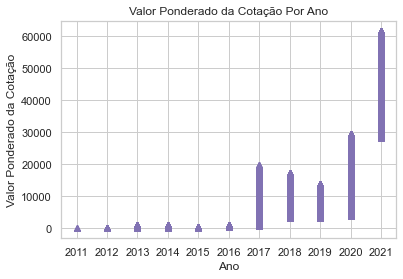

In [51]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

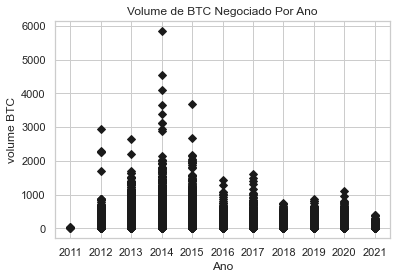

In [52]:
# Plot do Volume por ano
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

## Engenharia de Atributos com PySpark

In [53]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [54]:
# Prepara o vetor de atributos
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'], 
                            outputCol = "features")

In [55]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [56]:
# Visualiza os dados
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-30 23:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 07:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 08:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 09:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2011-12-31 20:16:00|[4.58,1.502,6.87916]          |


## Normalização

In [57]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7,.3], seed = rnd_seed)

In [58]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [59]:
# Cria o scaler
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [60]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

In [61]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [62]:
# Transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [63]:
dados_treino_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.557729822093386E-6,0.008199728766573702,1.51589789206087E-5]    |
|[4.5,37.86229723,171.38033753] |[1.1339679449941311E-5,0.006467928495112392,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.263564281564889E-5,0.001537449143732569,2.9653241795154263E-6]  |
|[4.84,10.0,48.4]               |[1.6847523754198516E-5,0.001708276826369521,3.4818459555688167E-6] |
|[5.0,10.1,50.5]                |[1.9439450485613674E-5,0.0017253595946332162,3.63291778421953E-6]  |
|[5.14,0.68,3.4952]             |[2.170738637560193E-5,1.1616282419312745E-4,2.5144107404760596E-7] |
|[5.26,29.31939163,154.21999997]|[2.36513314241633E-5,0.00500856372847815,1.109442

In [64]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Machine Learning

> Versão 1 do Modelo (Benchmark)

In [65]:
# Cria o modelo de regressão
modelo_lr_v1 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price', 
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [66]:
# Treina o modelo
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

22/07/08 15:35:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/07/08 15:35:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Se tiver mensagem de WARN, isso indica que o Spark não encontrou a biblioteca de otimização de álgebra linear (que precisa ser instalada, mas não é requerida para este projeto). Mais detalhes aqui:

https://spark.apache.org/docs/latest/ml-linalg-guide.html

In [67]:
# Salva o modelo em disco
modelo_v1.write().overwrite().save("modelos/modelo_v1")

## Avaliação do Modelo

In [68]:
# Previsões com dados de teste
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [69]:
# Seleciona as colunas
pred_data_v1 = previsoes_v1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.452060192894729|          4.39|
|7.641960478636686|          4.58|
|8.061740057645222|           5.0|
|8.381572117842202|          5.32|
|8.351587862198736|          5.29|
|8.351587862198736|          5.29|
| 8.25164034338718|          5.19|
|8.421551125366825|  5.3604618117|
|8.811346448731895|   5.777027027|
|9.061215245760785|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [70]:
# Mean Absolute Error
print("Mean Absolute Error (MAE) nos dados de teste: {0}".format(modelo_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 5.017385733181623


In [71]:
# Cria um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [72]:
# Aplica o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v1)

Root Mean Squared Error (RMSE) nos dados de teste = 11.2879


In [73]:
# Extrai as previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

In [74]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

In [75]:
# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

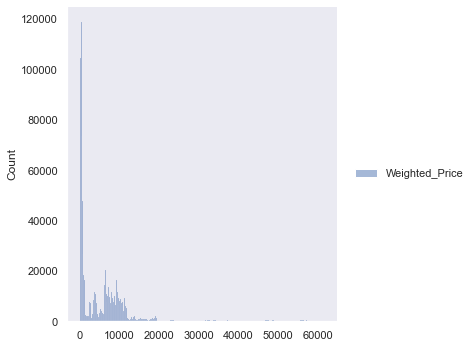

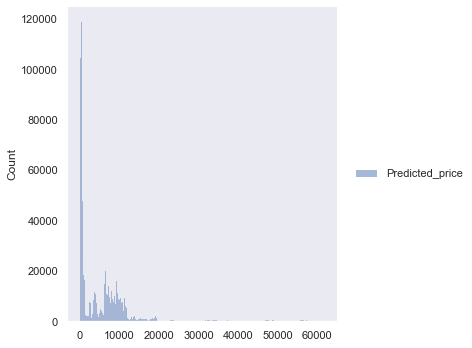

In [76]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

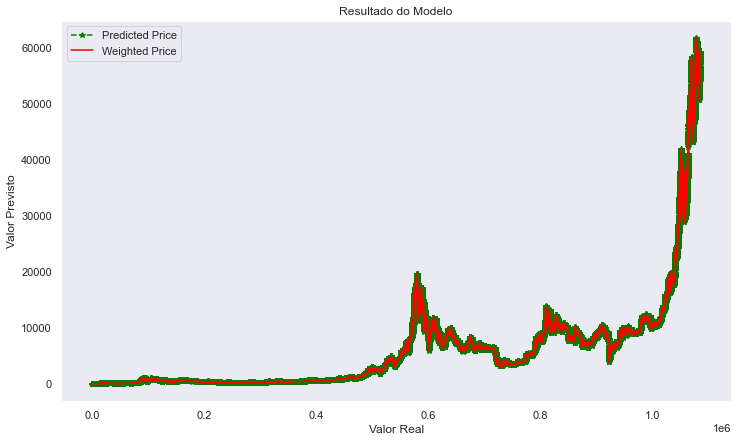

In [77]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

> Versão 2 do Modelo (Otimização de Hiperparâmetros)

In [78]:
# Cria o modelo
modelo_lr_v2 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price'))

In [79]:
# Cria um grid para otimização de hiperparâmetros
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [80]:
# Cria o avaliador (será usado na validação cruzada)
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [81]:
# Cria o CrossValidator
cv = CrossValidator(estimator = modelo_lr_v2, estimatorParamMaps = grid, evaluator = evaluator, parallelism = 2)

In [82]:
# Treina o CrossValidator
cvModel = cv.fit(dados_treino_scaled)

22/07/08 15:49:52 WARN Instrumentation: [fa30e54f] regParam is zero, which might cause numerical instability and overfitting.
22/07/08 15:49:52 WARN Instrumentation: [f83accc2] regParam is zero, which might cause numerical instability and overfitting.


22/07/08 15:50:00 WARN MemoryStore: Not enough space to cache rdd_152_1 in memory! (computed 41.8 MiB so far)
22/07/08 15:50:00 WARN BlockManager: Persisting block rdd_152_1 to disk instead.


22/07/08 15:50:01 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


22/07/08 15:50:12 WARN Instrumentation: [d93dbcf1] regParam is zero, which might cause numerical instability and overfitting.
22/07/08 15:50:12 WARN Instrumentation: [5304e908] regParam is zero, which might cause numerical instability and overfitting.


22/07/08 15:50:21 WARN MemoryStore: Not enough space to cache rdd_250_2 in memory! (computed 41.8 MiB so far)
22/07/08 15:50:21 WARN BlockManager: Persisting block rdd_250_2 to disk instead.
22/07/08 15:50:21 WARN MemoryStore: Not enough space to cache rdd_250_1 in memory! (computed 41.8 MiB so far)
22/07/08 15:50:21 WARN BlockManager: Persisting block rdd_250_1 to disk instead.


22/07/08 15:50:33 WARN Instrumentation: [23b8922b] regParam is zero, which might cause numerical instability and overfitting.
22/07/08 15:50:33 WARN Instrumentation: [d497ea8a] regParam is zero, which might cause numerical instability and overfitting.


22/07/08 15:50:42 WARN MemoryStore: Not enough space to cache rdd_348_1 in memory! (computed 41.8 MiB so far)
22/07/08 15:50:42 WARN BlockManager: Persisting block rdd_348_1 to disk instead.


22/07/08 15:50:54 WARN Instrumentation: [fc1cd2c8] regParam is zero, which might cause numerical instability and overfitting.


In [83]:
# Extrai o melhor modelo do CrossValidator
modelo_v2 = cvModel.bestModel

In [84]:
# Salva o modelo em disco
modelo_v2.write().overwrite().save("modelos/modelo_v2")

## Avaliação do Modelo

In [85]:
# Previsões com dados de teste
previsoes_v2 = modelo_v2.transform(dados_teste_scaled)

In [86]:
# Seleciona as colunas
pred_data_v2 = previsoes_v2.select("Predicted_price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 4.508108472357593|          4.39|
| 4.697545264575934|          4.58|
| 5.108091101746675|           5.0|
| 5.437041429505176|          5.32|
| 5.392532805262221|          5.29|
| 5.402256707831288|          5.29|
|5.3069234754546475|          5.19|
| 5.470987379974378|  5.3604618117|
| 5.860328227652778|   5.777027027|
| 6.117129927737251|           6.0|
+------------------+--------------+
only showing top 10 rows



In [87]:
# Mean Absolute Error
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

MAE: 3.388028733539672


In [88]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [89]:
# Aplica o avaliador
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v2)

Root Mean Squared Error (RMSE) nos dados de teste = 10.3524


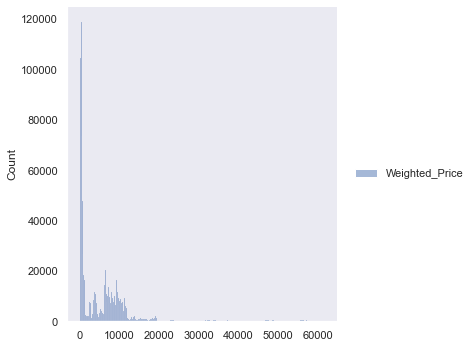

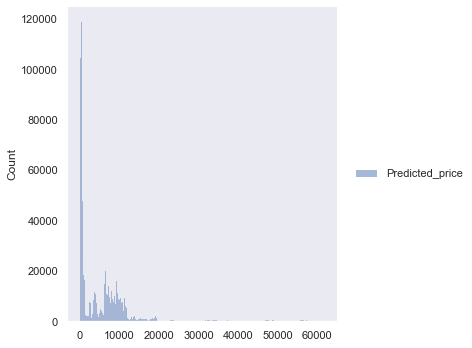

In [90]:
# Plot dos valores reais x valores previstos

# Extrai as previsões
pred_results_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v2.predictions.select("Predicted_price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

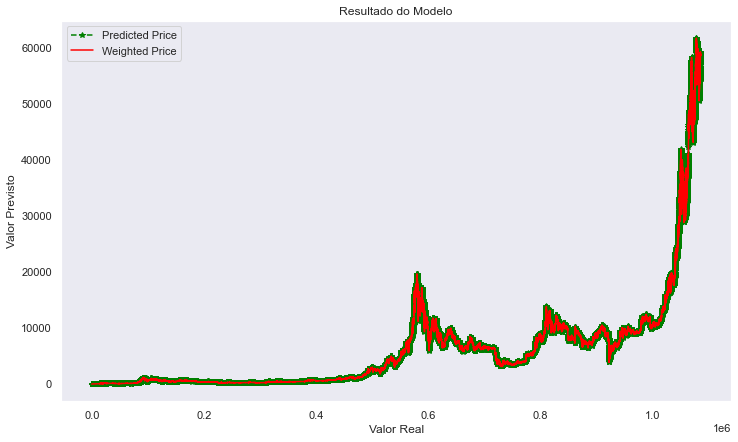

In [91]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

As mensagens de WARN no treinamento do modelo_v2 indicam que o modelo parece instável e talvez esteja com overfitting. Usaremos o modelo_v1.

## Previsões em Tempo Real

In [92]:
# Novos dados
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [93]:
# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [94]:
# Visualiza
df_novos_dados

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [95]:
# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados) 

In [96]:
# Schema
df_novos_dados_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [97]:
# Visualiza
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [98]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [99]:
# Visualiza os dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [100]:
# Normaliza os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [101]:
# Previsões com os novos dados
previsoes = modelo_v1.transform(df_assembled_scaled)

In [102]:
# Imprime as previsões
pred_data = previsoes.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
| 20538.57142694398|
|21612.567485085438|
+------------------+



In [103]:
# Encerra a sessão Spark
spark_session.stop()

# Fim